### Project description

The project is about predicting the number of recommendations of a comment performed on New York Times Comments
dataset that can be found under the link https://www.kaggle.com/datasets/aashita/nyt-comments.
Main challanges of this project are:
* handling large data volume
* feature engineering
* etc..
To 

### Imports

In [1]:
import findspark
findspark.init()
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import DateType
import pandas as pd

In [2]:
from pyspark import SparkContext, SparkConf
conf = SparkConf().setMaster("local[8]").setAppName("big_data")
sc = SparkContext.getOrCreate(conf=conf)

22/06/25 16:09:20 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


In [3]:
spark = SparkSession.builder.getOrCreate()

### Reading data

In [19]:
def read_spark_df(path):
    return spark.read.option("multiline",True).option('lineSep','\n').option("header", True).option("delimiter", ",").option("inferSchema",True).option("escapeQuotes", True).option("quote", "\"").option("escape", "\"").csv(path)

In [20]:
import pandas as pd

In [21]:
articles_pd_df = pd.read_csv('data/nyt-articles-2020.csv')

In [22]:
articles_pd_df

,newsdesk,section,subsection,material,headline,abstract,keywords,word_count,pub_date,n_comments,uniqueID
0,Editorial,Opinion,NaN,Editorial,Protect Veterans From Fraud,Congress could do much more to protect America...,"['Veterans', 'For-Profit Schools', 'Financial ...",680,2020-01-01 00:18:54+00:00,186,nyt://article/69a7090b-9f36-569e-b5ab-b0ba5bb3...
1,Games,Crosswords & Games,NaN,News,‘It’s Green and Slimy’,Christina Iverson and Jeff Chen ring in the Ne...,['Crossword Puzzles'],931,2020-01-01 03:00:10+00:00,257,nyt://article/9edddb54-0aa3-5835-a833-d311a76f...
2,Science,Science,NaN,News,Meteor Showers in 2020 That Will Light Up Nigh...,"All year long, Earth passes through streams of...","['Meteors and Meteorites', 'Space and Astronom...",1057,2020-01-01 05:00:08+00:00,6,nyt://article/04bc90f0-b20b-511c-b5bb-3ce13194...
3,Science,Science,NaN,Interactive Feature,Sync your calendar with the solar system,"Never miss an eclipse, a meteor shower, a rock...","['Space and Astronomy', 'Moon', 'Eclipses', 'S...",0,2020-01-01 05:00:12+00:00,2,nyt://interactive/5b58d876-9351-50af-9b41-a312...
4,Science,Science,NaN,News,"Rocket Launches, Trips to Mars and More 2020 S...",A year full of highs and lows in space just en...,"['Space and Astronomy', 'Private Spaceflight',...",1156,2020-01-01 05:02:38+00:00,25,nyt://article/bd8647b3-8ec6-50aa-95cf-2b81ed12...
...,...,...,...,...,...,...,...,...,...,...,...
16782,Editorial,Opinion,NaN,Op-Ed,What It Takes to Heal From Covid-19,"Survivors can get better, but they need help.","['Chronic Condition (Health)', 'Coronavirus (2...",1002,2020-12-31 15:27:47+00:00,166,nyt://article/e8adbb75-a8b3-5a8c-886b-b9c1195f...
16783,Sports,Sports,Baseball,News,Padres Jolt M.L.B. With Bold Moves to Set Up W...,While many teams continued to assess the finan...,"['San Diego Padres', 'Major League Baseball', ...",1100,2020-12-31 15:47:44+00:00,42,nyt://article/1f11417d-2c57-51b9-b75d-8f67f0a9...
16784,Business,Business Day,NaN,News,"Their Finances Ravaged, Customers Fear Banks W...",Banks have the power to decide whether to let ...,"['Banking and Financial Institutions', 'Corona...",1429,2020-12-31 16:21:40+00:00,556,nyt://article/c4b9edab-bdde-5d81-b496-06fedb52...
16785,Dining,Food,"Wine, Beer & Cocktails",News,Should Wine Be Among Your Health Resolutions?,The new category of ‘clean wines’ is an effort...,"['Wines', 'Grapes', 'Diet and Nutrition', 'Dia...",1307,2020-12-31 17:28:11+00:00,277,nyt://article/efcaf652-ffad-5b4e-9f17-4fd9aff5...


In [23]:
import numpy as np
import json

In [24]:
def remove_semicolons(x):
    if type(x) != float:
#         print(x)
        x = literal_eval(x)
        for i in range(len(x)):
            x[i] = x[i].replace(",","")
        return x
    else:
        return None

In [25]:
from ast import literal_eval

In [26]:
articles_pd_df['keywords'] = articles_pd_df['keywords'].apply(lambda x: remove_semicolons(x))

In [27]:
articles_pd_df['headline'] = articles_pd_df['headline'].str.replace(",",'')
articles_pd_df['abstract'] = articles_pd_df['abstract'].str.replace(",",'')
articles_pd_df['subsection'] = articles_pd_df['subsection'].str.replace(",",'')
articles_pd_df['section'] = articles_pd_df['section'].str.replace(",",'') 
articles_pd_df['newsdesk'] = articles_pd_df['newsdesk'].str.replace(",",'') 

In [28]:
articles_pd_df

,newsdesk,section,subsection,material,headline,abstract,keywords,word_count,pub_date,n_comments,uniqueID
0,Editorial,Opinion,NaN,Editorial,Protect Veterans From Fraud,Congress could do much more to protect America...,"[Veterans, For-Profit Schools, Financial Aid (...",680,2020-01-01 00:18:54+00:00,186,nyt://article/69a7090b-9f36-569e-b5ab-b0ba5bb3...
1,Games,Crosswords & Games,NaN,News,‘It’s Green and Slimy’,Christina Iverson and Jeff Chen ring in the Ne...,[Crossword Puzzles],931,2020-01-01 03:00:10+00:00,257,nyt://article/9edddb54-0aa3-5835-a833-d311a76f...
2,Science,Science,NaN,News,Meteor Showers in 2020 That Will Light Up Nigh...,All year long Earth passes through streams of ...,"[Meteors and Meteorites, Space and Astronomy, ...",1057,2020-01-01 05:00:08+00:00,6,nyt://article/04bc90f0-b20b-511c-b5bb-3ce13194...
3,Science,Science,NaN,Interactive Feature,Sync your calendar with the solar system,Never miss an eclipse a meteor shower a rocket...,"[Space and Astronomy, Moon, Eclipses, Seasons ...",0,2020-01-01 05:00:12+00:00,2,nyt://interactive/5b58d876-9351-50af-9b41-a312...
4,Science,Science,NaN,News,Rocket Launches Trips to Mars and More 2020 Sp...,A year full of highs and lows in space just en...,"[Space and Astronomy, Private Spaceflight, Roc...",1156,2020-01-01 05:02:38+00:00,25,nyt://article/bd8647b3-8ec6-50aa-95cf-2b81ed12...
...,...,...,...,...,...,...,...,...,...,...,...
16782,Editorial,Opinion,NaN,Op-Ed,What It Takes to Heal From Covid-19,Survivors can get better but they need help.,"[Chronic Condition (Health), Coronavirus (2019...",1002,2020-12-31 15:27:47+00:00,166,nyt://article/e8adbb75-a8b3-5a8c-886b-b9c1195f...
16783,Sports,Sports,Baseball,News,Padres Jolt M.L.B. With Bold Moves to Set Up W...,While many teams continued to assess the finan...,"[San Diego Padres, Major League Baseball, Free...",1100,2020-12-31 15:47:44+00:00,42,nyt://article/1f11417d-2c57-51b9-b75d-8f67f0a9...
16784,Business,Business Day,NaN,News,Their Finances Ravaged Customers Fear Banks Wi...,Banks have the power to decide whether to let ...,"[Banking and Financial Institutions, Coronavir...",1429,2020-12-31 16:21:40+00:00,556,nyt://article/c4b9edab-bdde-5d81-b496-06fedb52...
16785,Dining,Food,Wine Beer & Cocktails,News,Should Wine Be Among Your Health Resolutions?,The new category of ‘clean wines’ is an effort...,"[Wines, Grapes, Diet and Nutrition, Diaz Camer...",1307,2020-12-31 17:28:11+00:00,277,nyt://article/efcaf652-ffad-5b4e-9f17-4fd9aff5...


In [46]:
articles_df = read_spark_df('data/nyt-articles-2020.csv')


comments_df = read_spark_df('data/nyt-comments-2020.csv')

In [47]:
comments_df = comments_df.limit(1000)

In [48]:
df = comments_df.withColumn("updateDate", comments_df['updateDate'].cast(DateType()))

In [49]:
comments_df.printSchema()

root
 |-- commentID: integer (nullable = true)
 |-- status: string (nullable = true)
 |-- commentSequence: integer (nullable = true)
 |-- userID: integer (nullable = true)
 |-- userDisplayName: string (nullable = true)
 |-- userLocation: string (nullable = true)
 |-- userTitle: string (nullable = true)
 |-- commentBody: string (nullable = true)
 |-- createDate: string (nullable = true)
 |-- updateDate: string (nullable = true)
 |-- approveDate: string (nullable = true)
 |-- recommendations: integer (nullable = true)
 |-- replyCount: integer (nullable = true)
 |-- editorsSelection: boolean (nullable = true)
 |-- parentID: double (nullable = true)
 |-- parentUserDisplayName: string (nullable = true)
 |-- depth: integer (nullable = true)
 |-- commentType: string (nullable = true)
 |-- trusted: integer (nullable = true)
 |-- recommendedFlag: integer (nullable = true)
 |-- permID: integer (nullable = true)
 |-- isAnonymous: boolean (nullable = true)
 |-- articleID: string (nullable = true)


We can observe that although we used inferSchema some of the columns should be stored as a different data type. Let's fix it.

In [50]:
comments_df=comments_df.withColumn('recommendations',comments_df['recommendations'].cast("float"))\
                        .withColumn("createDate", comments_df['createDate'].cast(DateType()))\
                        .withColumn("updateDate", comments_df['updateDate'].cast(DateType()))\
                        .withColumn("approveDate", comments_df['approveDate'].cast(DateType()))\
                        .withColumn('replyCount',comments_df['replyCount'].cast("int"))\
                        .withColumn('depth',comments_df['depth'].cast("int"))\
                        .withColumn('isAnonymous',comments_df['isAnonymous'].cast("int"))\
                        .withColumn('editorsSelection',comments_df['editorsSelection'].cast("int"))
#actually some of the above columns are boolean but pyspark does not provide such datatype so we cast them to int

In [51]:
articles_df = articles_df.withColumn('word_count',articles_df['word_count'].cast("int"))\
                         .withColumn("pub_date", articles_df['pub_date'].cast(DateType()))\
                         .withColumn('n_comments',articles_df['n_comments'].cast("int"))

In [52]:
comments_df.printSchema()

root
 |-- commentID: integer (nullable = true)
 |-- status: string (nullable = true)
 |-- commentSequence: integer (nullable = true)
 |-- userID: integer (nullable = true)
 |-- userDisplayName: string (nullable = true)
 |-- userLocation: string (nullable = true)
 |-- userTitle: string (nullable = true)
 |-- commentBody: string (nullable = true)
 |-- createDate: date (nullable = true)
 |-- updateDate: date (nullable = true)
 |-- approveDate: date (nullable = true)
 |-- recommendations: float (nullable = true)
 |-- replyCount: integer (nullable = true)
 |-- editorsSelection: integer (nullable = true)
 |-- parentID: double (nullable = true)
 |-- parentUserDisplayName: string (nullable = true)
 |-- depth: integer (nullable = true)
 |-- commentType: string (nullable = true)
 |-- trusted: integer (nullable = true)
 |-- recommendedFlag: integer (nullable = true)
 |-- permID: integer (nullable = true)
 |-- isAnonymous: integer (nullable = true)
 |-- articleID: string (nullable = true)



In [53]:
articles_df.printSchema()

root
 |-- newsdesk: string (nullable = true)
 |-- section: string (nullable = true)
 |-- subsection: string (nullable = true)
 |-- material: string (nullable = true)
 |-- headline: string (nullable = true)
 |-- abstract: string (nullable = true)
 |-- keywords: string (nullable = true)
 |-- word_count: integer (nullable = true)
 |-- pub_date: date (nullable = true)
 |-- n_comments: integer (nullable = true)
: string (nullable = true)



Let's take a look at our target variable

In [54]:
comments_df.describe(['recommendations']).show()

+-------+-----------------+
|summary|  recommendations|
+-------+-----------------+
|  count|             1000|
|   mean|           11.986|
| stddev|27.61623545055446|
|    min|              0.0|
|    max|            402.0|
+-------+-----------------+



We can observe that data is contains outliers. We will get rid of them using quantiles.

In [55]:
upper_limit = comments_df.approxQuantile('recommendations', [ 0.9], 0.05)[0]

In [56]:
comments_df = comments_df.filter((col('recommendations')<upper_limit))

In [57]:
comments_df.describe(['recommendations']).show()

+-------+-----------------+
|summary|  recommendations|
+-------+-----------------+
|  count|              852|
|   mean|4.772300469483568|
| stddev|5.022607677901019|
|    min|              0.0|
|    max|             20.0|
+-------+-----------------+



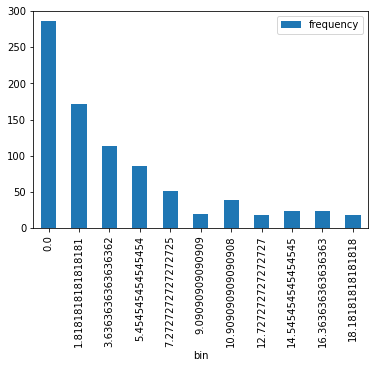

In [58]:
gre_histogram = comments_df.select('recommendations').rdd.flatMap(lambda x: x).histogram(11)

# Loading the Computed Histogram into a Pandas Dataframe for plotting
pd.DataFrame(
    list(zip(*gre_histogram)), 
    columns=['bin', 'frequency']
).set_index(
    'bin'
).plot(kind='bar');

Transformr text to vectors

In [59]:
# from pyspark.mllib.feature import Word2Vec

In [60]:
from pyspark.ml.feature import StopWordsRemover,Word2Vec
from pyspark.sql.functions import monotonically_increasing_id, row_number
from pyspark.sql.window import Window
import pyspark.sql.functions as F

In [71]:
comments_df=comments_df.withColumn("createDateInt", F.unix_timestamp(comments_df['createDate']))

aritcles_data = articles_df.select(col("abstract"),col("pub_date"),
                          col("keywords"),
                          col("uniqueID\r").alias('articleID'))
aritcles_data = aritcles_data.withColumn("pubDateInt", F.unix_timestamp(col('pub_date')))
aritcles_data = aritcles_data.filter(~ col('abstract').isNull()) # TODO: nie wywalać tylko uzpełniać średnią wartośćią z wektorów
# data = data.withColumn("articleID",expr("substring(articleID, 1, length(articleID)-1)"))
# full_df = comments_df.join(data, on=["articleID"])

# full_df = full_df.withColumn('time_passed', abs(full_df['pubDateInt'] - full_df['createDateInt']))

# a = comments_df.select('articleID').distinct().take(1)
# b = data.select(col('articleID')).take(1)
# print(a, b)

In [72]:
articles_df.show()

+--------------+------------------+-----------+-------------------+--------------------+--------------------+--------------------+----------+----------+----------+--------------------+
|
+--------------+------------------+-----------+-------------------+--------------------+--------------------+--------------------+----------+----------+----------+--------------------+
|     Editorial|           Opinion|       null|          Editorial|Protect Veterans ...|Congress could do...|['Veterans', 'For...|       680|2020-01-01|       186|nyt://article/69a...|
|         Games|Crosswords & Games|       null|               News|‘It’s Green and S...|Christina Iverson...|['Crossword Puzzl...|       931|2020-01-01|       257|nyt://article/9ed...|
|       Science|           Science|       null|               News|Meteor Showers in...|All year long, Ea...|['Meteors and Met...|      1057|2020-01-01|         6|nyt://article/04b...|
|       Science|           Science|       null|Interactive Feature|Sync y

In [73]:
aritcles_data.show()

+--------------------+----------+--------------------+--------------------+----------+
|            abstract|  pub_date|            keywords|           articleID|pubDateInt|
+--------------------+----------+--------------------+--------------------+----------+
|Congress could do...|2020-01-01|['Veterans', 'For...|nyt://article/69a...|1577833200|
|Christina Iverson...|2020-01-01|['Crossword Puzzl...|nyt://article/9ed...|1577833200|
|All year long, Ea...|2020-01-01|['Meteors and Met...|nyt://article/04b...|1577833200|
|Never miss an ecl...|2020-01-01|['Space and Astro...|nyt://interactive...|1577833200|
|A year full of hi...|2020-01-01|['Space and Astro...|nyt://article/bd8...|1577833200|
|Iran’s ability to...|2020-01-01|['Iraq', 'Iran', ...|nyt://article/ac7...|1577833200|
|If you brother-in...|2020-01-01|['Comedy and Humor']|nyt://article/dea...|1577833200|
|After the 67-year...|2020-01-01|['Stroke', 'Brain...|nyt://article/dfd...|1577833200|
|Tangy and juicy, ...|2020-01-01|['Cooking 

In [79]:
def get_vector(df,column='commentBody',leave_columns =["commentID"]):
    df = df.withColumn(column, trim(regexp_replace(column,'(@\w+)|[^a-zA-Z\s]', '')))
    df = df.select(*leave_columns,split(col(column)," ").alias(column))
    remover = StopWordsRemover(inputCol=column, outputCol="filtered")
    filtered = remover.transform(df)
    word2vec = Word2Vec(inputCol="filtered", outputCol="feature_comment_body")
    model = word2vec.fit(filtered)
    return model.transform(filtered)

In [75]:
aritcles_data.filter(col('abstract').isNull()).show()

+--------+--------+--------+---------+----------+
|abstract|pub_date|keywords|articleID|pubDateInt|
+--------+--------+--------+---------+----------+
+--------+--------+--------+---------+----------+



In [81]:
comments_df_leave_columns = ['commentID','createDate','approveDate','recommendations','articleID','replyCount']

In [94]:
articles_columns = aritcles_data.columns
articles_columns.pop(articles_columns.index('abstract'))
articles_df_leave_columns = articles_columns

In [95]:
df = get_vector(comments_df,leave_columns=comments_df_leave_columns)
df2 = get_vector(aritcles_data, column='abstract',leave_columns = articles_df_leave_columns)

22/06/25 16:23:51 WARN StopWordsRemover: Default locale set was [en_PL]; however, it was not found in available locales in JVM, falling back to en_US locale. Set param `locale` in order to respect another locale.
22/06/25 16:23:52 WARN StopWordsRemover: Default locale set was [en_PL]; however, it was not found in available locales in JVM, falling back to en_US locale. Set param `locale` in order to respect another locale.


In [101]:
df.show()
df2.show()

+---------+----------+-----------+---------------+--------------------+----------+--------------------+--------------------+--------------------+
|commentID|createDate|approveDate|recommendations|           articleID|replyCount|         commentBody|            filtered|feature_comment_body|
+---------+----------+-----------+---------------+--------------------+----------+--------------------+--------------------+--------------------+
|104387472|2020-01-01| 2020-01-01|            7.0|nyt://article/69a...|         5|[Here, is, someth...|[something, think...|[0.00240626834177...|
|104387873|2020-01-01| 2020-01-01|           17.0|nyt://article/69a...|         0|[I, have, used, m...|[used, VA, loan, ...|[0.00249493141346...|
|104387976|2020-01-01| 2020-01-01|            8.0|nyt://article/69a...|         0|[would, someone, ...|[someone, take, V...|[-0.0072937462265...|
|104390628|2020-01-01| 2020-01-01|            1.0|nyt://article/69a...|         0|[here, in, the, A...|[Alabama, PNW, tr...|

In [104]:
df2.columns

['pub_date',
 'keywords',
 'articleID',
 'pubDateInt',
 'abstract',
 'filtered',
 'feature_comment_body']

In [103]:
df.columns

['commentID',
 'createDate',
 'approveDate',
 'recommendations',
 'articleID',
 'replyCount',
 'commentBody',
 'filtered',
 'feature_comment_body']

In [105]:
full_df = df.join(df2,on='articleID',how='inner')

In [106]:
full_df.columns

['articleID',
 'commentID',
 'createDate',
 'approveDate',
 'recommendations',
 'replyCount',
 'commentBody',
 'filtered',
 'feature_comment_body',
 'pub_date',
 'keywords',
 'pubDateInt',
 'abstract',
 'filtered',
 'feature_comment_body']

In [61]:
df = df.withColumn('row_index', row_number().over(Window.orderBy(monotonically_increasing_id())))
full_df = full_df.withColumn('row_index', row_number().over(Window.orderBy(monotonically_increasing_id())))
full_df = full_df.join(df, on=["row_index"]).drop("row_index")

In [62]:
df2 = df2.select(col("vector").alias('abstract_vector'))
df2 = df2.withColumn('row_index', row_number().over(Window.orderBy(monotonically_increasing_id())))
full_df = full_df.withColumn('row_index', row_number().over(Window.orderBy(monotonically_increasing_id())))
full_df = full_df.join(df2, on=["row_index"]).drop("row_index")

In [64]:
from pyspark.ml.feature import VectorAssembler

numericCols = ['vector', 'abstract_vector', 'time_passed']
assembler = VectorAssembler(inputCols=numericCols, outputCol="features")
full_df = assembler.transform(full_df)

In [65]:
full_df = full_df.drop(*numericCols)

In [66]:
from pyspark.ml.feature import Bucketizer
bucketizer = Bucketizer(splits=[ 0, 6, 12, 18, float('Inf') ],inputCol="recommendations", outputCol="buckets")
full_df = bucketizer.setHandleInvalid("keep").transform(full_df)

In [68]:
full_df.printSchema()

root
 |-- articleID: string (nullable = true)
 |-- commentID: integer (nullable = true)
 |-- status: string (nullable = true)
 |-- commentSequence: integer (nullable = true)
 |-- userID: integer (nullable = true)
 |-- userDisplayName: string (nullable = true)
 |-- userLocation: string (nullable = true)
 |-- userTitle: string (nullable = true)
 |-- commentBody: string (nullable = true)
 |-- createDate: date (nullable = true)
 |-- updateDate: date (nullable = true)
 |-- approveDate: date (nullable = true)
 |-- recommendations: float (nullable = true)
 |-- replyCount: integer (nullable = true)
 |-- editorsSelection: integer (nullable = true)
 |-- parentID: string (nullable = true)
 |-- parentUserDisplayName: string (nullable = true)
 |-- depth: integer (nullable = true)
 |-- commentType: string (nullable = true)
 |-- trusted: string (nullable = true)
 |-- recommendedFlag: integer (nullable = true)
 |-- permID: string (nullable = true)
 |-- isAnonymous: integer (nullable = true)
 |-- creat

In [69]:
#### TODO ####

# from pyspark.mllib.linalg.distributed import RowMatrix
# from pyspark.mllib.linalg import Vectors, VectorUDT
# from pyspark.sql.functions import udf, array

# mat = RowMatrix(full_df.select('features'))
# pc = mat.computePrincipalComponents(10)
# projected = mat.multiply(pc)

IllegalArgumentException: requirement failed: DataFrame must have a single vector type column

In [43]:
from pyspark.ml import Pipeline
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.feature import IndexToString, StringIndexer, VectorIndexer
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Load and parse the data file, converting it to a DataFrame.
data = full_df

# Index labels, adding metadata to the label column.
# Fit on whole dataset to include all labels in index.
labelIndexer = StringIndexer(inputCol="buckets", outputCol="indexedLabel").fit(data)

# Automatically identify categorical features, and index them.
# Set maxCategories so features with > 4 distinct values are treated as continuous.
featureIndexer =\
    VectorIndexer(inputCol="features", outputCol="indexedFeatures").fit(data)

# Split the data into training and test sets (30% held out for testing)
(trainingData, testData) = data.randomSplit([0.7, 0.3])

# Train a RandomForest model.
rf = RandomForestClassifier(labelCol="buckets", featuresCol="indexedFeatures")

# Convert indexed labels back to original labels.
labelConverter = IndexToString(inputCol="prediction", outputCol="predictedLabel",
                               labels=labelIndexer.labels)

# Chain indexers and forest in a Pipeline
pipeline = Pipeline(stages=[labelIndexer, featureIndexer, rf, labelConverter])

# Train model.  This also runs the indexers.
model = pipeline.fit(trainingData)

# Make predictions.
predictions = model.transform(testData)

# Select example rows to display.
predictions.select("predictedLabel", "buckets", "features").show(15)

# Select (prediction, true label) and compute test error
evaluator = MulticlassClassificationEvaluator(
    labelCol="buckets", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("Test Error = %g" % (1.0 - accuracy))

rfModel = model.stages[2]
print(rfModel)  # summary only

+--------------+-------+--------------------+
|predictedLabel|buckets|            features|
+--------------+-------+--------------------+
|           0.0|    3.0|[-0.0213082146025...|
|           0.0|    2.0|[0.00879926614080...|
|           0.0|    0.0|[-0.0183993745595...|
|           0.0|    0.0|(201,[100,101,102...|
|           0.0|    0.0|[0.01398731380322...|
|           0.0|    0.0|[0.03632894159718...|
|           0.0|    0.0|[0.03271815881181...|
|           0.0|    0.0|[0.05916589977568...|
|           0.0|    0.0|[0.07192069188588...|
|           0.0|    0.0|[0.08958277180499...|
|           0.0|    0.0|[0.02133534631866...|
|           0.0|    0.0|[0.02119789324014...|
|           0.0|    0.0|[-0.0079683041221...|
|           0.0|    0.0|[0.00568002799179...|
|           0.0|    0.0|[0.01157510414682...|
+--------------+-------+--------------------+
only showing top 15 rows

Test Error = 0.335054
RandomForestClassificationModel: uid=RandomForestClassifier_3e3fb794058f, numT